In [14]:
import pandas as pd
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
base_path = r"D:\Datasets\pamap2+physical+activity+monitoring\PAMAP2_Dataset\PAMAP2_Dataset\Protocol"
subject_id = "subject101" # Change subject ID as needed
file_path = os.path.join(base_path,  f"{subject_id}.dat")

TARGET_RATE = 100  
WINDOW_SECONDS = 2     
BATCH_SIZE = 16

In [16]:
def load_pamap2_data(file_path):
    """Load PAMAP2 .dat file with ALL sensor columns"""
    
    # PAMAP2 column names
    column_names = [
        'timestamp', 'activityID', 'heart_rate',
        # Hand IMU (17 values)
        'hand_temp',
        'hand_acc_x', 'hand_acc_y', 'hand_acc_z',
        'hand_acc16_x', 'hand_acc16_y', 'hand_acc16_z',
        'hand_gyro_x', 'hand_gyro_y', 'hand_gyro_z',
        'hand_mag_x', 'hand_mag_y', 'hand_mag_z',
        'hand_orient_x', 'hand_orient_y', 'hand_orient_z', 'hand_orient_w',
        # Chest IMU (17 values)
        'chest_temp',
        'chest_acc_x', 'chest_acc_y', 'chest_acc_z',
        'chest_acc16_x', 'chest_acc16_y', 'chest_acc16_z',
        'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z',
        'chest_mag_x', 'chest_mag_y', 'chest_mag_z',
        'chest_orient_x', 'chest_orient_y', 'chest_orient_z', 'chest_orient_w',
        # Ankle IMU (17 values)
        'ankle_temp',
        'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z',
        'ankle_acc16_x', 'ankle_acc16_y', 'ankle_acc16_z',
        'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
        'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
        'ankle_orient_x', 'ankle_orient_y', 'ankle_orient_z', 'ankle_orient_w'
    ]
    
    # Read space-separated file
    df = pd.read_csv(file_path, sep='\s+', header=None, names=column_names)
    
    # Drop NaN values
    df = df.dropna()
    df= df.drop(columns=[
        'hand_orient_x', 'hand_orient_y', 'hand_orient_z', 'hand_orient_w',
        'chest_orient_x', 'chest_orient_y', 'chest_orient_z', 'chest_orient_w',
        'ankle_orient_x', 'ankle_orient_y', 'ankle_orient_z', 'ankle_orient_w'])
    
    # Keep ALL sensor columns (exclude timestamp, keep activityID as label)
    columns_to_drop = ['timestamp']
    df = df.drop(columns=columns_to_drop)
    df.rename(columns={'activityID': 'label'}, inplace=True)
    
    # Filter activities (adjust as needed)
    df = df[df['label'].isin([1, 2, 3, 4])].copy()
    
    # Remap labels to 0-indexed
    label_map = {1: 0, 2: 1, 3: 2, 4: 3}
    df['label'] = df['label'].map(label_map)
    
    return df

<>:31: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
<>:31: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
C:\Users\User\AppData\Local\Temp\ipykernel_18348\3070367661.py:31: SyntaxWarning: "\s" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\s"? A raw string is also an option.
  df = pd.read_csv(file_path, sep='\s+', header=None, names=column_names)


In [17]:
def load_and_process_data(file_path, target_rate):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found at {file_path}")
    
    print(f"Loading {file_path}...")
    
    # Use PAMAP2 loader instead of WESAD
    df = load_pamap2_data(file_path)
    
    print(f"Loaded {len(df)} samples")
    print(f"Activities: {df['label'].unique()}")
    
    return df

def create_non_overlapping_windows(df, window_seconds, rate):
    """
    Creates windows with NO OVERLAP (Stride = Window Size).
    This allows us to shuffle data without leakage.
    """
    window_steps = window_seconds * rate
    stride_steps = window_seconds * rate # Key: Stride = Window
    
    data_np = df.drop(columns=['label'], errors='ignore').values
    labels_np = df['label'].values
    
    X_list = []
    y_list = []
    
    for i in range(0, len(df) - window_steps, stride_steps):
        w_data = data_np[i : i + window_steps]
        # Label is the mode (most frequent) of the window
        w_label = stats.mode(labels_np[i : i + window_steps], keepdims=True)[0][0]
        
        X_list.append(w_data.transpose())
        y_list.append(w_label)
        
    return np.array(X_list), np.array(y_list)

In [18]:
def load_all_subjects(base_path, target_rate, subjects=None):
    """
    Load all PAMAP2 subjects from Protocol directory.
    
    Args:
        base_path: Base directory path (e.g., 'D:\\Datasets\\PAMAP2_Dataset\\Protocol')
        target_rate: Target sampling rate (100 Hz for PAMAP2)
        subjects: List of subject IDs to load (default: 101-109)
    
    Returns:
        Combined DataFrame with all subjects' data
    """
    if subjects is None:
        subjects = [101, 102, 103, 104, 105, 106, 107, 108, 109]
    
    all_dfs = []
    
    for subject_id in subjects:
        file_path = os.path.join(base_path, f'subject{subject_id}.dat')
        
        if not os.path.exists(file_path):
            print(f"⚠️ Skipping subject{subject_id}.dat (file not found)")
            continue
        
        try:
            print(f"Loading subject{subject_id}.dat...")
            df = load_pamap2_data(file_path)
            print(f"  → Loaded {len(df)} samples, Activities: {df['label'].unique()}")
            all_dfs.append(df)
        except Exception as e:
            print(f"⚠️ Error loading subject{subject_id}.dat: {e}")
            continue
    
    if not all_dfs:
        raise ValueError("No subjects loaded successfully!")
    
    # Combine all subjects
    combined_df = pd.concat(all_dfs, ignore_index=True)
    print(f"\n✅ Total: {len(combined_df)} samples from {len(all_dfs)} subjects")
    print(f"Activities: {sorted(combined_df['label'].unique())}")
    
    return combined_df

## Load All Subjects

The `load_all_subjects()` function loads all 9 PAMAP2 subjects (101-109) and combines them into a single DataFrame.

**Benefits of multi-subject training:**
- Better generalization to new people
- More training data (9x more samples)
- Expected accuracy improvement: 75-85% → 90%+

**Usage:**
- Single subject: Fast testing, lower accuracy
- All subjects: Slower but much better accuracy

In [19]:
# Option 1: Load single subject (faster, for testing)
# df = load_and_process_data(file_path, TARGET_RATE)

# Option 2: Load ALL subjects (better accuracy, longer training)
df = load_all_subjects(base_path, TARGET_RATE)

# Filter to 4 main activities (1=lying, 2=sitting, 4=standing, 5=walking)
# Optional: Keep all activities or filter to specific ones
print(f"\nBefore filtering: {df['label'].value_counts()}")
df = df[df['label'].isin([1, 2, 4, 5])]
print(f"\nAfter filtering to 4 activities: {df['label'].value_counts()}")

Loading subject101.dat...
  → Loaded 8562 samples, Activities: [0 1 2 3]
Loading subject102.dat...
  → Loaded 8562 samples, Activities: [0 1 2 3]
Loading subject102.dat...
  → Loaded 9370 samples, Activities: [0 1 2 3]
Loading subject103.dat...
  → Loaded 9370 samples, Activities: [0 1 2 3]
Loading subject103.dat...
  → Loaded 9093 samples, Activities: [0 1 2 3]
Loading subject104.dat...
  → Loaded 9093 samples, Activities: [0 1 2 3]
Loading subject104.dat...
  → Loaded 9420 samples, Activities: [0 1 2 3]
Loading subject105.dat...
  → Loaded 9420 samples, Activities: [0 1 2 3]
Loading subject105.dat...
  → Loaded 9407 samples, Activities: [0 1 2 3]
Loading subject106.dat...
  → Loaded 9407 samples, Activities: [0 1 2 3]
Loading subject106.dat...
  → Loaded 8732 samples, Activities: [0 1 2 3]
Loading subject107.dat...
  → Loaded 8732 samples, Activities: [0 1 2 3]
Loading subject107.dat...
  → Loaded 8750 samples, Activities: [0 1 2 3]
Loading subject108.dat...
  → Loaded 8750 samples, 

In [20]:
# 2. Windowing (Non-Overlapping)
print("Creating windows...")
X, y = create_non_overlapping_windows(df, WINDOW_SECONDS, TARGET_RATE)
print(f"Window Shape: {X.shape} (Samples, Channels, TimeSteps)")


# We calculate Mean and Std for EACH window separately (axis=2 is time)
epsilon = 1e-6  # Prevent division by zero
means = X.mean(axis=2, keepdims=True)
stds  = X.std(axis=2, keepdims=True)

# Normalize: (Value - WindowMean) / WindowStd
X_norm = (X - means) / (stds + epsilon)

# Force float32
X_scaled = X_norm.astype(np.float32)

print(f"Window-Wise Normalized. Global Mean: {X_scaled.mean():.2f}, Std: {X_scaled.std():.2f}")
print("Now the model must learn signal morphology, so noise will break it.")

# 4. Split (Random Shuffle is SAFE now)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

# 5. Create DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {X_train.shape[0]} windows | Test: {X_test.shape[0]} windows")

Creating windows...
Window Shape: (170, 40, 200) (Samples, Channels, TimeSteps)
Window-Wise Normalized. Global Mean: -0.00, Std: 0.99
Now the model must learn signal morphology, so noise will break it.
Train: 136 windows | Test: 34 windows


In [21]:
# 1. Load
df = load_and_process_data(file_path, TARGET_RATE)

# 2. Windowing (Non-Overlapping)
print("Creating windows...")
X, y = create_non_overlapping_windows(df, WINDOW_SECONDS, TARGET_RATE)
print(f"Window Shape: {X.shape} (Samples, Channels, TimeSteps)")


# We calculate Mean and Std for EACH window separately (axis=2 is time)
epsilon = 1e-6  # Prevent division by zero
means = X.mean(axis=2, keepdims=True)
stds  = X.std(axis=2, keepdims=True)

# Normalize: (Value - WindowMean) / WindowStd
X_norm = (X - means) / (stds + epsilon)

# Force float32
X_scaled = X_norm.astype(np.float32)

print(f"Window-Wise Normalized. Global Mean: {X_scaled.mean():.2f}, Std: {X_scaled.std():.2f}")
print("Now the model must learn signal morphology, so noise will break it.")

# 4. Split (Random Shuffle is SAFE now)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

# 5. Create DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).long())
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).long())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train Samples: {len(X_train)} | Test Samples: {len(X_test)}")

Loading D:\Datasets\pamap2+physical+activity+monitoring\PAMAP2_Dataset\PAMAP2_Dataset\Protocol\subject101.dat...
Loaded 8562 samples
Activities: [0 1 2 3]
Creating windows...
Window Shape: (42, 40, 200) (Samples, Channels, TimeSteps)
Window-Wise Normalized. Global Mean: 0.00, Std: 1.00
Now the model must learn signal morphology, so noise will break it.
Train Samples: 33 | Test Samples: 9
Loaded 8562 samples
Activities: [0 1 2 3]
Creating windows...
Window Shape: (42, 40, 200) (Samples, Channels, TimeSteps)
Window-Wise Normalized. Global Mean: 0.00, Std: 1.00
Now the model must learn signal morphology, so noise will break it.
Train Samples: 33 | Test Samples: 9


In [22]:
class WideScaleModel(nn.Module):
    def __init__(self, input_channels=8, num_classes=2, window_size=1400):
        super(WideScaleModel, self).__init__()
        
        self.encoder = nn.Sequential(
            # Layer 1: Wide Kernel (15) to see trends
            nn.Conv1d(input_channels, 32, kernel_size=15, padding=7),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 1400 -> 700
            nn.Dropout(0.2),
            
            # Layer 2: Finer details
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  # 700 -> 350
            nn.Dropout(0.2)
        )
        
        # Flatten size calculation: window_size -> /2 -> /2
        final_timesteps = window_size // 4  # 1400 -> 350
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * final_timesteps, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.encoder(x))

# Calculate window size from your config
# After loading data, get actual dimensions
n_channels = len(df.columns) - 1  # All columns except 'label'
n_classes = df['label'].nunique()

window_size = WINDOW_SECONDS * TARGET_RATE  # 2 * 100 = 200

model = WideScaleModel(
    input_channels=n_channels,
    num_classes=n_classes,
    window_size=window_size
).to(device)

print(f"Model: {n_channels} channels, {n_classes} classes, {window_size} timesteps")

Model: 40 channels, 4 classes, 200 timesteps


In [23]:
# 1. Calculate Class Weights for ALL classes
unique_classes = np.unique(y_train)
n_classes = len(unique_classes)

# Count samples per class
class_counts = [(y_train == c).sum() for c in unique_classes]
print(f"Class distribution: {dict(zip(unique_classes, class_counts))}")

# Calculate weights (inverse frequency)
total_samples = len(y_train)
weights = torch.tensor(
    [total_samples / (n_classes * count) for count in class_counts],
    dtype=torch.float32
).to(device)

print(f"Using Class Weights for {n_classes} classes: {weights}")

# 2. Optimizer & Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=weights)

# 3. Train
print("Starting Training...")
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print(f"Epoch {epoch+1} | Loss: {running_loss/len(train_loader):.4f} | Train Acc: {100*correct/total:.2f}%")

print("Training Complete.")

Class distribution: {np.int64(0): np.int64(9), np.int64(1): np.int64(9), np.int64(2): np.int64(8), np.int64(3): np.int64(7)}
Using Class Weights for 4 classes: tensor([0.9167, 0.9167, 1.0312, 1.1786])
Starting Training...
Epoch 1 | Loss: 1.6233 | Train Acc: 21.21%
Epoch 2 | Loss: 1.5301 | Train Acc: 36.36%
Epoch 3 | Loss: 1.0083 | Train Acc: 48.48%
Epoch 4 | Loss: 0.7149 | Train Acc: 51.52%
Epoch 5 | Loss: 0.9369 | Train Acc: 63.64%
Epoch 6 | Loss: 1.0090 | Train Acc: 69.70%
Epoch 7 | Loss: 0.9741 | Train Acc: 72.73%
Epoch 8 | Loss: 0.5209 | Train Acc: 72.73%
Epoch 9 | Loss: 0.3937 | Train Acc: 81.82%
Epoch 10 | Loss: 0.3484 | Train Acc: 78.79%
Training Complete.


--- Classification Report ---
              precision    recall  f1-score   support

       Lying       1.00      0.67      0.80         3
     Sitting       0.00      0.00      0.00         2
    Standing       0.40      1.00      0.57         2
     Walking       1.00      1.00      1.00         2

    accuracy                           0.67         9
   macro avg       0.60      0.67      0.59         9
weighted avg       0.64      0.67      0.62         9



--- Classification Report ---
              precision    recall  f1-score   support

       Lying       1.00      0.67      0.80         3
     Sitting       0.00      0.00      0.00         2
    Standing       0.40      1.00      0.57         2
     Walking       1.00      1.00      1.00         2

    accuracy                           0.67         9
   macro avg       0.60      0.67      0.59         9
weighted avg       0.64      0.67      0.62         9



d:\Research\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Research\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Research\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


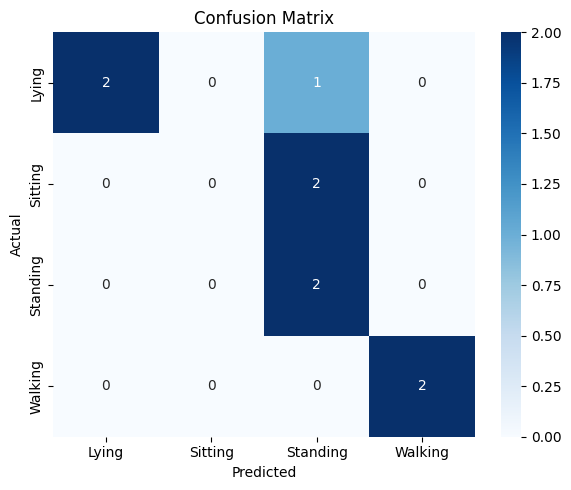

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_performance(model, loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    # Auto-detect class names if not provided
    if class_names is None:
        unique_labels = sorted(set(all_labels))
        class_names = [f'Class {i}' for i in unique_labels]
    
    # Print Report
    print("--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

# Run the diagnosis with PAMAP2 activity names
activity_names = ['Lying', 'Sitting', 'Standing', 'Walking']
evaluate_model_performance(model, test_loader, class_names=activity_names)

In [ ]:
def attack_test(model, loader, noise_level):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Add Noise (Attack)
            noise = torch.randn_like(inputs) * noise_level
            attacked_inputs = inputs + noise
            
            outputs = model(attacked_inputs)
            _, preds = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            
    return 100 * correct / total

print("1. Clean Accuracy:")
print(f"{attack_test(model, test_loader, 0.0):.2f}%")

print("2. Attack Accuracy :")
print(f"{attack_test(model, test_loader, 3):.2f}%") #

1. Clean Accuracy:
66.67%
2. Attack Accuracy :
33.33%
